## Code required to create Figure 1
*From "Exploring uncertainty of trends in the lower-tropospheric North Pacific Jet."* 

Entire notebook takes: ~20 seconds on Intel i7-10750 using > 4GB RAM

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
## Statistics#
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import adfuller, kpss ## Augmented Dickey-Fuller test for non-stationarity in time series
from statsmodels.tsa.seasonal import seasonal_decompose
import pymannkendall

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
START_YEAR = "1980"
END_YEAR = "2022"

In [3]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['GrisePolvani2014_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
# era_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]


In [4]:
b18_data = pd.DataFrame([pd.date_range('1959', periods=64, freq='AS'),\
                         era_npac_day_dict['Bracegirdle2018_NorthPacific']['annual_JPOS'],
                        ]).T
b18_data.columns = ['time', 'annual_JPOS']
b18_data = b18_data.set_index('time')
b18_data = b18_data[START_YEAR:END_YEAR]

In [5]:
## Note Kerr et al. 2020 is lon mean
metric_data = pd.DataFrame(era_npac_day_dict['Woollings2010_NorthPacific']['jet_lat'])
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_w10'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['BarnesPolvani2013_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_bp13'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['GrisePolvani2014_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_gp14'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['BarnesPolvani2015_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_bp15'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['BarnesSimpson2017_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_bs17'})
# metric_data = pd.concat([metric_data, b18_data], axis=1)
# metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_b18'})
# metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['Ceppi2018_NorthPacific']['jet_lat'])], axis=1)
# metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_c18'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['Zappa2018_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_z18'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['Kerr2020_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_k20'})


In [6]:
metric_data.index = pd.to_datetime(metric_data.index)

In [7]:
metric_data = pd.concat([metric_data, b18_data], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_b18'})

In [8]:
metric_data['annual_JPOS'] = metric_data['annual_JPOS'].astype(float)

In [9]:
PDO_data = pd.read_csv('data/PacificDecadalOscillation.csv', skiprows=11, header=None, sep='\s\s')
PDO_data.columns = ['time', 'pdo'] 
PDO_data['time'] = PDO_data['time'].apply(lambda t: datetime.datetime.strptime(str(t), '%Y%m%d'))
PDO_data = PDO_data.set_index('time')
PDO_data = PDO_data.loc["1979":]

/tmp/ipykernel_30697/2520827410.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  PDO_data = pd.read_csv('data/PacificDecadalOscillation.csv', skiprows=11, header=None, sep='\s\s')


In [10]:
MSLP_data = xr.open_dataset('data/era5_mslp_79to21_NH_monthly.nc')
MSLP_data = MSLP_data.drop_vars('expver')
MSLP_data = MSLP_data.sel(time=slice("1979", None))

In [11]:
npac_mslp = MSLP_data.sel(latitude=slice(90, 0), longitude=slice(120, 240))

In [12]:
t2m_data = xr.open_dataset('../../Climate Data/ERA-5/era_mon_temp_40to23.nc')
t2m_data = t2m_data.sel(time=slice("1979", None))

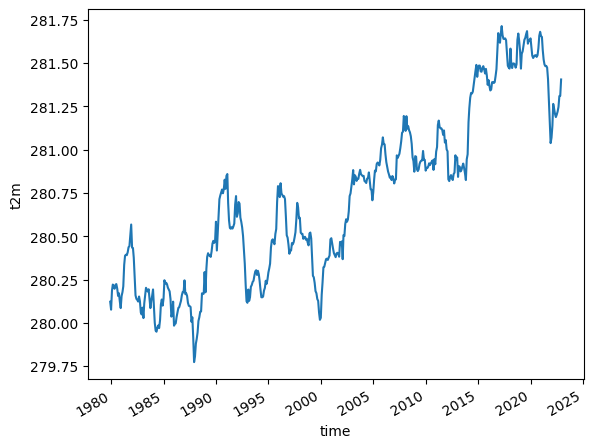

In [13]:
npac_t2m_mean = t2m_data.sel(latitude=slice(90, 0), longitude=slice(120, 240))['t2m'].mean(('latitude', 'longitude'))
npac_t2m_mean.rolling(time=12).mean().plot()

### Make mean sea level pressure and t2m gradient calculations

In [14]:
npac_temp = t2m_data.sel(latitude=slice(90, 0), longitude=slice(120, 240))
npac_temp['t2m_mean_poleward_grad'] = (('time'),\
                                       np.array(list(map(lambda row: np.mean(np.gradient(row)), npac_temp.mean('longitude')['t2m']))))

Text(0.5, 1.0, 'Monthly poleward temperature')

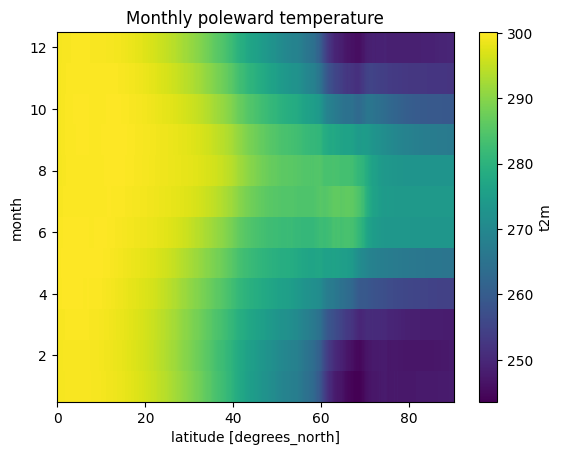

In [15]:
npac_temp.mean('longitude').groupby('time.month').mean()['t2m'].plot()
plt.title("Monthly poleward temperature")

Text(0.5, 1.0, 'Monthly poleward MSLP')

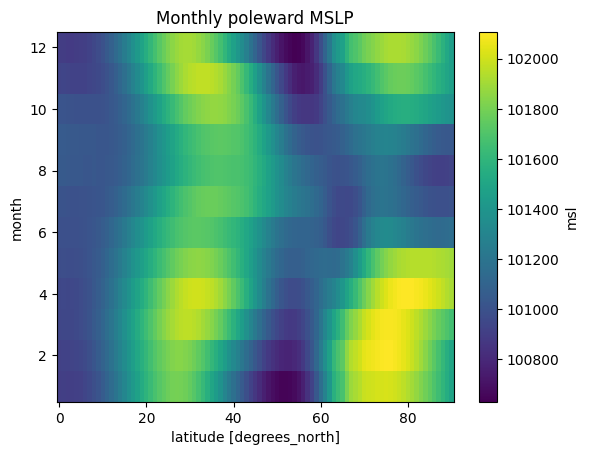

In [16]:
npac_mslp.mean('longitude').groupby('time.month').mean()['msl'].plot()
plt.title("Monthly poleward MSLP")

In [17]:
npac_mslp = npac_mslp.sortby('latitude', ascending=True)
data = npac_mslp.mean('longitude')['msl'].groupby('time.month').mean().sel(month=5)

In [18]:
def get_crossover_points(data, backup_first_index=20, backup_second_index=45, backup_third_index=70):
    assert len(data.dims) == 1, "this method only works when there is one dimension: latitude"
    data_mean = data.mean()
    first_index = get_first_index(data, data_mean)
    
    try:
        second_index = get_nth_index(data, data_mean, first_index)
    except IndexError:
        second_index = backup_second_index
        
    try:
        third_index = get_nth_index(data, data_mean, second_index, func=np.greater)
    except IndexError:
        third_index = backup_third_index

    if first_index >= second_index or first_index >= third_index:
        first_index = backup_first_index
        
    if second_index >= third_index:
        second_index = backup_second_index 
        third_index = backup_third_index
        
    return first_index, second_index, third_index

def get_first_index(data, data_mean):
    return np.where(data - data_mean > 0)[0][0]

def get_nth_index(data, data_mean, previous_index, func=np.less):
    return previous_index + np.where(func(data[previous_index:] - data_mean, 0))[0][0]


def get_msl_peak_and_trough(data, first_index, second_index, third_index):
    peak = data.sel(latitude=slice(first_index, second_index))
    trough = data.sel(latitude=slice(second_index, third_index))
    peak_lat = peak['latitude'][np.where(peak == peak.max())[0][0]]
    trough_lat = trough['latitude'][np.where(trough == trough.min())[0][0]]
    return peak_lat, trough_lat


def get_msl_low_and_high(data, first_index, second_index, third_index, num_vals_to_include=3):
    """
    Method to get top 3 and bottom 3 msl values in peak and trough
    """
    subtrop_msl_high = sorted(data.sel(latitude=slice(first_index, second_index)).data, reverse=True)[:num_vals_to_include]
    mid_lat_msl_low = sorted(data.sel(latitude=slice(second_index, third_index)).data, reverse=False)[:num_vals_to_include]
    return subtrop_msl_high, mid_lat_msl_low


## Metrics for gradient calculation
def calc_mean_peak_trough_gradient(data,  first_index, second_index, third_index):
    peak_lat, trough_lat = get_msl_peak_and_trough(data,  first_index, second_index, third_index)
    return np.mean(np.gradient(data.sel(latitude=slice(peak_lat,trough_lat))))


def calc_difference_in_msl(data, first_index, second_index, third_index):
    subtrop_msl_high, mid_lat_msl_low = get_msl_low_and_high(data, first_index, second_index, third_index)
    return subtrop_msl_high - mid_lat_msl_low


def run_msl_gradient_metric(data, grad_func=calc_mean_peak_trough_gradient):
    try:
        first_index, second_index, third_index = get_crossover_points(data)
    except IndexError:
        return np.nan
    return grad_func(data,  first_index, second_index, third_index)
    


In [20]:
first_index, second_index, third_index = get_crossover_points(data)
subtrop_msl_high, mid_lat_msl_low = get_msl_low_and_high(data, first_index, second_index, third_index)
print(np.mean(subtrop_msl_high) - np.mean(mid_lat_msl_low))
peak_lat, trough_lat = get_msl_peak_and_trough(data, first_index, second_index, third_index)
print(float(peak_lat), float(trough_lat))
print("mean gradient", np.mean(np.gradient(data.sel(latitude=slice(peak_lat,trough_lat)))))

780.15625
32.0 54.0
mean gradient -34.200577


Text(60, 102010, '       3rd\n intersection')

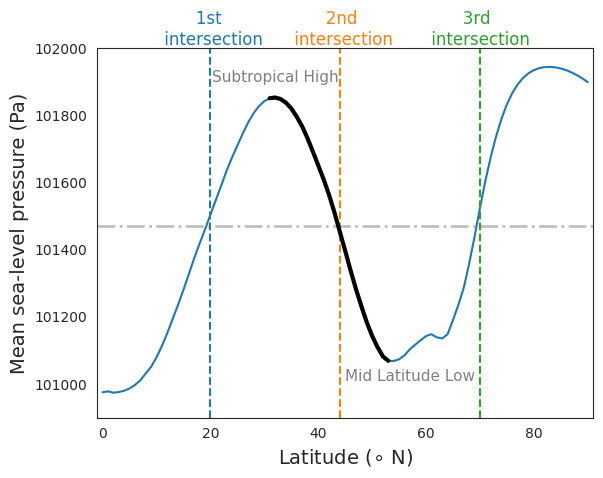

In [22]:
sns.set_style("white")
data.plot()
plt.vlines(data['latitude'][first_index], 100900, 102000, 'C0', '--')
plt.vlines(data['latitude'][second_index], 100900, 102000, 'C1', '--')
plt.vlines(data['latitude'][third_index], 100900, 102000, 'C2', '--')
# plt.hlines(101853, -1, 91, 'grey', '--', alpha=.5)
# plt.hlines(101080, -1, 91, 'grey', '--', alpha=.5)
plt.hlines(data.mean(), -1, 91, 'grey', '-.', linewidth=2, alpha=.5)
data.sel(latitude=slice(31, 53)).plot(c='k', linewidth=3)
plt.text(s="Subtropical High", x=20.3, y=101900, c='grey', fontsize=11)
plt.text(s="Mid Latitude Low", x=45, y=101010, c='grey', fontsize=11)
plt.xlim(-1, 91)
plt.ylim(100900, 102000)
plt.ylabel("Mean sea-level pressure (Pa)", size=14)
plt.xlabel(r"Latitude ($\circ$ N)", size=14)
plt.title("")
plt.text(s="       1st\n intersection", x=10.5, y=102010, c='C0', fontsize=12)
plt.text(s="       2nd\n intersection", x=34.5, y=102010, c='C1', fontsize=12)
plt.text(s="       3rd\n intersection", x=60, y=102010, c='C2', fontsize=12)
# plt.savefig("figures/supplementary_MSL_calculation_diagram.png". bbox_inches='tight')

In [23]:
%%time
npac_mslp['msl_hightolow_mean_grad'] = (('time'), np.array(list(map(run_msl_gradient_metric, npac_mslp.mean('longitude')['msl']))))

CPU times: user 4.4 s, sys: 1.02 ms, total: 4.4 s
Wall time: 4.39 s


# Make Figure 1

In [25]:
clim_data = pd.concat([PDO_data, npac_mslp['msl_hightolow_mean_grad'].to_dataframe()], axis=1)
clim_data = clim_data.join(npac_t2m_mean.to_dataframe())
clim_data['temp_anom'] = (npac_t2m_mean.groupby('time.dayofyear') - npac_t2m_mean.groupby('time.dayofyear').mean('time')).to_dataframe()['t2m']
clim_data = clim_data.join(npac_temp['t2m_mean_poleward_grad'].to_dataframe())
all_data = pd.concat([clim_data, metric_data], axis=1)

In [26]:
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

In [27]:
all_data_1m_resampled = all_data.resample('1m').mean()

In [29]:
## Get Correlation
kendall_corr_set = all_data_1m_resampled.drop(['jet_lat_bp15', 'annual_JPOS'], axis=1).corr('kendall')
kendall_corr_set = kendall_corr_set[kendall_corr_set != 1]

In [31]:
WINDOW_SIZE = 12 # 12 months

Mann Kendall test for pdo trend decreasing p-value: 2.4404479104234156e-08 slope -0.02172670807453416
Mann Kendall test for msl_hightolow_mean_grad trend no trend p-value: 0.8680303548128956 slope 0.007423152271498982
Mann Kendall test for temp_anom trend increasing p-value: 0.0 slope 0.031152845262647506
Mann Kendall test for t2m_mean_poleward_grad trend decreasing p-value: 0.0007895013327332556 slope -4.1294109189149104e-05
Mann Kendall test for jet_lat_w10 trend no trend p-value: 0.07814931235303457 slope 0.026445328864683655
Mann Kendall test for jet_lat_bp13 trend no trend p-value: 0.10714274335640961 slope 0.023713073005093552
Mann Kendall test for jet_lat_gp14 trend increasing p-value: 0.04731505694442695 slope 0.024287370862323465
Mann Kendall test for jet_lat_bs17 trend no trend p-value: 0.07618834370046468 slope 0.022857889237199544
Mann Kendall test for annual_JPOS trend no trend p-value: 0.27608355517070216 slope 0.025
Mann Kendall test for jet_lat_z18 trend increasing p-va

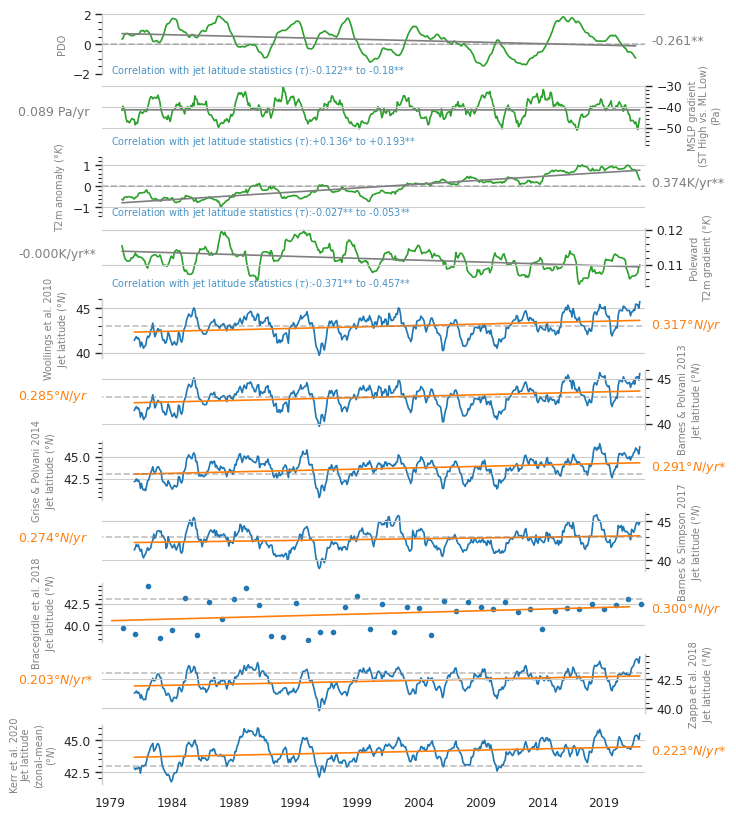

In [45]:
sns.set_style('whitegrid')
sns.set_context('paper')
fig, axes = plt.subplots(11, 1, figsize=(7, 10), sharex=True, \
                         height_ratios=[0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5])
# all_data_rolling = all_data.rolling(window=365).mean()
# all_data_rolling_missing_vals = all_data.rolling(window=365, min_periods=8).mean()
# all_data_rolling['temp_anom'] = (all_data_rolling['t2m'] - all_data_rolling['t2m'].mean())
cols_to_plot = ['pdo', 'msl_hightolow_mean_grad', 'temp_anom', 't2m_mean_poleward_grad',\
                'jet_lat_w10', 'jet_lat_bp13', 'jet_lat_gp14', 'jet_lat_bs17',\
                'annual_JPOS', 'jet_lat_z18', 'jet_lat_k20'] #'jet_lat_bp15',

ylabels = ["PDO", "MSLP gradient\n(ST High vs. ML Low)\n(Pa)", "T2m anomaly (${\degree K}$)", "Poleward\nT2m gradient (${\degree K}$)",\
           "Woollings et al. 2010\nJet latitude (${\degree N}$)",\
           "Barnes & Polvani 2013\nJet latitude (${\degree N}$)",\
           "Grise & Polvani 2014\nJet latitude (${\degree N}$)",\
           "Barnes & Simpson 2017\nJet latitude (${\degree N}$)",\
          "Bracegirdle et al. 2018\nJet latitude (${\degree N}$)",\
           "Zappa et al. 2018\nJet latitude (${\degree N}$)",\
          "Kerr et al. 2020\nJet latitude\n(zonal-mean)\n(${\degree N}$)"]

slope_units = ["", " Pa/yr", "K/yr", "K/yr"]

all_data_1m_resampled['pdo'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[0], c='C2')
axes[0].set_ylim(-2, 2)
axes[0].hlines(0, 100, 648, alpha=.5, color='grey', linestyle='--')
all_data_1m_resampled['msl_hightolow_mean_grad'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[1], c='C2')
axes[1].set_ylim(-58, -30)
all_data_1m_resampled['temp_anom'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[2], c='C2')
axes[2].set_ylim(-1.4, 1.4)
axes[2].hlines(0, 100, 648, alpha=.5, color='grey', linestyle='--')
all_data_1m_resampled['t2m_mean_poleward_grad'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[3], c='C2')
all_data_1m_resampled['jet_lat_w10'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[4], c="C0")
all_data_1m_resampled['jet_lat_bp13'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[5], c="C0")
# all_data_1m_resampled['jet_lat_bp15'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[6], c="C0")
all_data_1m_resampled['jet_lat_gp14'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[6], c="C0")
all_data_1m_resampled['jet_lat_bs17'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[7], c="C0")
all_data_1m_resampled['annual_JPOS'].plot(ax=axes[8], marker='o', markersize=3, c="C0")
all_data_1m_resampled['jet_lat_z18'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[9], c="C0")
# axes[10].set_ylim(26, 42)
all_data_1m_resampled['jet_lat_k20'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[10], c="C0")

counter = 0 
for ax, col_name, ylabel in zip(axes, cols_to_plot, ylabels):
    if counter % 2 == 1:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        twin_ax = ax.twinx()
        twin_ax.set_ylim(ax.get_ylim())
        twin_ax.spines['top'].set_visible(False) 
        twin_ax.spines['bottom'].set_visible(False)
        twin_ax.spines['left'].set_visible(False)
        ax.spines['left'].set_visible(False)
        twin_ax.set_ylabel(ylabel, size=7, color='grey')
        twin_ax.minorticks_on()
        twin_ax.tick_params(axis='y',which='major', right=True)
        twin_ax.tick_params(axis='y',which='minor', right=True)
        twin_ax.hlines(43, 0, 680, color='gray', alpha=0.5, linestyle='--')
        ax.set_yticks([])
    else:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_ylabel(ylabel, size=7, color='grey'); 
    
    ax.spines['top'].set_visible(False); 
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False); 
    ax.set_title('')
    if col_name == "annual_JPOS":
        color_to_use = 'C1'
        lin_reg_line = get_linear_reg_slope(pd.DataFrame(all_data_1m_resampled[col_name]), col_name)
        lin_reg_line.plot(ax=ax, c=color_to_use, legend=False)
    elif col_name in cols_to_plot[:4]:
        color_to_use = 'C7'
        # Work around because first columns are monthly res
        lin_reg_line = get_linear_reg_slope(pd.DataFrame(all_data_1m_resampled[col_name].rolling(window=WINDOW_SIZE).mean()), col_name)
        lin_reg_line.plot(ax=ax, c=color_to_use, legend=False)
    else:
        color_to_use = 'C1'
        # try:
        #     lin_reg_line = get_linear_reg_slope(all_data_rolling, col_name)
        # except:
        lin_reg_line = get_linear_reg_slope(pd.DataFrame(all_data_1m_resampled[col_name].rolling(window=WINDOW_SIZE).mean()), col_name)
        lin_reg_line.plot(ax=ax, c='C1', legend=False)
    # if counter == 4:
    #     break
    slope_by_year = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
    if counter < 4:
        slope_label = slope_units[counter]
    else:
        slope_label = "${\degree N/yr}$"
        
    ## run Augmented Dickey Fuller
    if col_name == 'annual_JPOS':
        mktest = pymannkendall.original_test(all_data_1m_resampled[col_name].dropna())
    elif col_name in cols_to_plot[:4]:
        mktest = pymannkendall.seasonal_test(all_data_1m_resampled[col_name].dropna(), period=12)
    else:
        mktest = pymannkendall.seasonal_test(all_data_1m_resampled[col_name].dropna(), period=12)
    print("Mann Kendall test for", col_name, "trend", mktest.trend, "p-value:", mktest.p, "slope", mktest.slope)
    if mktest.p <= 0.05:
        slope_label += "*"
    if mktest.p <= 0.01:
        slope_label += "*"
    else:
        pass
    slope_by_year = mktest.slope*12
    if counter % 2 == 1:
        ymin, ymax = twin_ax.get_ylim()
        twin_ax.text(s=f"{slope_by_year:.3f}{slope_label}", x=twin_ax.get_xlim()[0]-90, y=(ymin + ymax)/2, fontsize=9, c=color_to_use)
    else:
        ymin, ymax = ax.get_ylim()
        ax.text(s=f"{slope_by_year:.3f}{slope_label}", x=ax.get_xlim()[-1]+10, y=(ymin + ymax)/2, fontsize=9, c=color_to_use)
        
    ax.grid(axis='x')
    ax.minorticks_on()
    ax.tick_params(axis='y',which='major', left=True)
    ax.tick_params(axis='y',which='minor', left=True)
    counter += 1

for n in range(0, 4):
    xmin, xmax = axes[n].get_xlim()
    ymin, ymax = axes[n].get_ylim()
    tau_min, tau_max = round(kendall_corr_set[cols_to_plot[n]].iloc[5:].min(), 3), round(kendall_corr_set[cols_to_plot[n]].iloc[5:].max(), 3) 
    if abs(tau_min) > abs(tau_max):
        axes[n].text(s="Correlation with jet latitude statistics "+r"($\tau$):"+f"{tau_max}** to {tau_min}**", x=xmin, y=ymin-(abs(ymin)//10), fontsize=7, c='C0', alpha=.8)
    else:
        asterixs = "**"
        if n == 1:
            asterixs = "*"
        axes[n].text(s="Correlation with jet latitude statistics "+r"($\tau$):"+f"+{tau_min}{asterixs} to +{tau_max}**", x=xmin, y=ymin, fontsize=7, c='C0', alpha=.8)
    
for n in range(4, 11):
    if n % 2 != 1:
        axes[n].hlines(43, 0, 680, color='gray', alpha=0.5, linestyle='--')

for ax in axes:
    ax.set_xlim(100, 628)
    
axes[-1].set_xlabel("")
fig.subplots_adjust(hspace=0.2)
# fig.savefig('figures/figure_1.png', dpi=300, bbox_inches='tight', transparent=False)